Guiding questions  
Which organisation launched the most space missions in a given year?  
How many launches were carried out per year?  
How has the cost of a space mission varied over time?  
Which months are the most popular for launches?  
Have space missions become safer or have the chances of failure remained unchanged? 


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Download Dataset and first look

In [20]:
df=pd.read_csv("..\Dataset\mission_launches.csv")
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\sebam\AppData\Local\Temp\ipykernel_10220\565713219.py:1: SyntaxWarning: invalid escape sequence '\D'
  df=pd.read_csv("..\Dataset\mission_launches.csv")


,Unnamed: 0.1,Unnamed: 0,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    4324 non-null   int64 
 1   Unnamed: 0      4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


We have many null values in the Price column that we need to address.  
The Date column is of type object; it would be better to convert it to datetime for easier processing.  
We can also delete one of the first two columns and rename the other for clarity.  
It would be helpful to extract and split the information in the Detail column for better understanding.  
The Price column should be converted to numeric.


In [22]:
df.isna().sum()

Unnamed: 0.1         0
Unnamed: 0           0
Organisation         0
Location             0
Date                 0
Detail               0
Rocket_Status        0
Price             3360
Mission_Status       0
dtype: int64

# CLEAN DATA

In [23]:
# Covert 'Date' column to datetime
df['Date'] = df['Date'].astype(str).str.replace('UTC', '', regex=False).str.strip() # Ensure 'Date' is a string before conversion
df['Date'] = pd.to_datetime(df.Date, format='mixed', dayfirst=True) # Convert to datetime in mixed format due to the presence of diferents formats


# Extract year and month from 'Date' column
df['Year'] = df['Date'].dt.year.astype('Int64')

ordered_months = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']

df['Month'] = pd.Categorical(df['Date'].dt.month_name(), categories=ordered_months, ordered=True)


# Delete the 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Rename 'Unnamed:01 column to 'id
df.rename(columns={'Unnamed: 0.1': 'id'}, inplace=True)

# Extract information from 'Detail' column
df[['Rocket', 'Mission']] = df['Detail'].str.split('|', expand=True)
df['Rocket'] = df['Rocket'].str.strip()
df['Mission'] = df['Mission'].str.strip()   
df.drop(columns=['Detail'], inplace=True)

# Convert 'Price' column to numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Replace 'Price' column NaN values 
# Step 1: Fill NaN values in 'Price' column with the mean of the respective organization, Rocket, and year
df['Price'] = df.groupby(['Organisation', 'Rocket', 'Year'])['Price'].transform(lambda x: x.fillna(x.mean()))

# Step 2: Fill NaN values in 'Price' column with the mean of the respective organization and Rocket
df['Price'] = df.groupby(['Organisation', 'Rocket'])['Price'].transform(lambda x: x.fillna(x.mean()))

# Step 3: Fill NaN values in 'Price' column with the mean of the respective organization
df['Price'] = df.groupby(['Organisation'])['Price'].transform(lambda x: x.fillna(x.mean()))

# Step4: Fill remaining NaN values in 'Price' column with the median of the entire column
df['Price'] = df['Price'].fillna(df['Price'].median())
df['Price'] = df['Price'].round(2)  # Round to 2 decimal places

# Verify the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              4324 non-null   int64         
 1   Organisation    4324 non-null   object        
 2   Location        4324 non-null   object        
 3   Date            4324 non-null   datetime64[ns]
 4   Rocket_Status   4324 non-null   object        
 5   Price           4324 non-null   float64       
 6   Mission_Status  4324 non-null   object        
 7   Year            4324 non-null   Int64         
 8   Month           4324 non-null   category      
 9   Rocket          4324 non-null   object        
 10  Mission         4324 non-null   object        
dtypes: Int64(1), category(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 346.8+ KB


In [24]:
df.head()

,id,Organisation,Location,Date,Rocket_Status,Price,Mission_Status,Year,Month,Rocket,Mission
0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00,StatusActive,50.00,Success,2020,August,Falcon 9 Block 5,Starlink V1 L9 & BlackSky
1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00,StatusActive,29.75,Success,2020,August,Long March 2D,Gaofen-9 04 & Q-SAT
2,2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00,StatusActive,54.99,Success,2020,August,Starship Prototype,150 Meter Hop
3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00,StatusActive,65.00,Success,2020,July,Proton-M/Briz-M,Ekspress-80 & Ekspress-103
4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00,StatusActive,145.00,Success,2020,July,Atlas V 541,Perseverance


# Analysis of the DataFrame

## Which organisation launched the most space missions in a given year?

<Figure size 1500x4000 with 0 Axes>

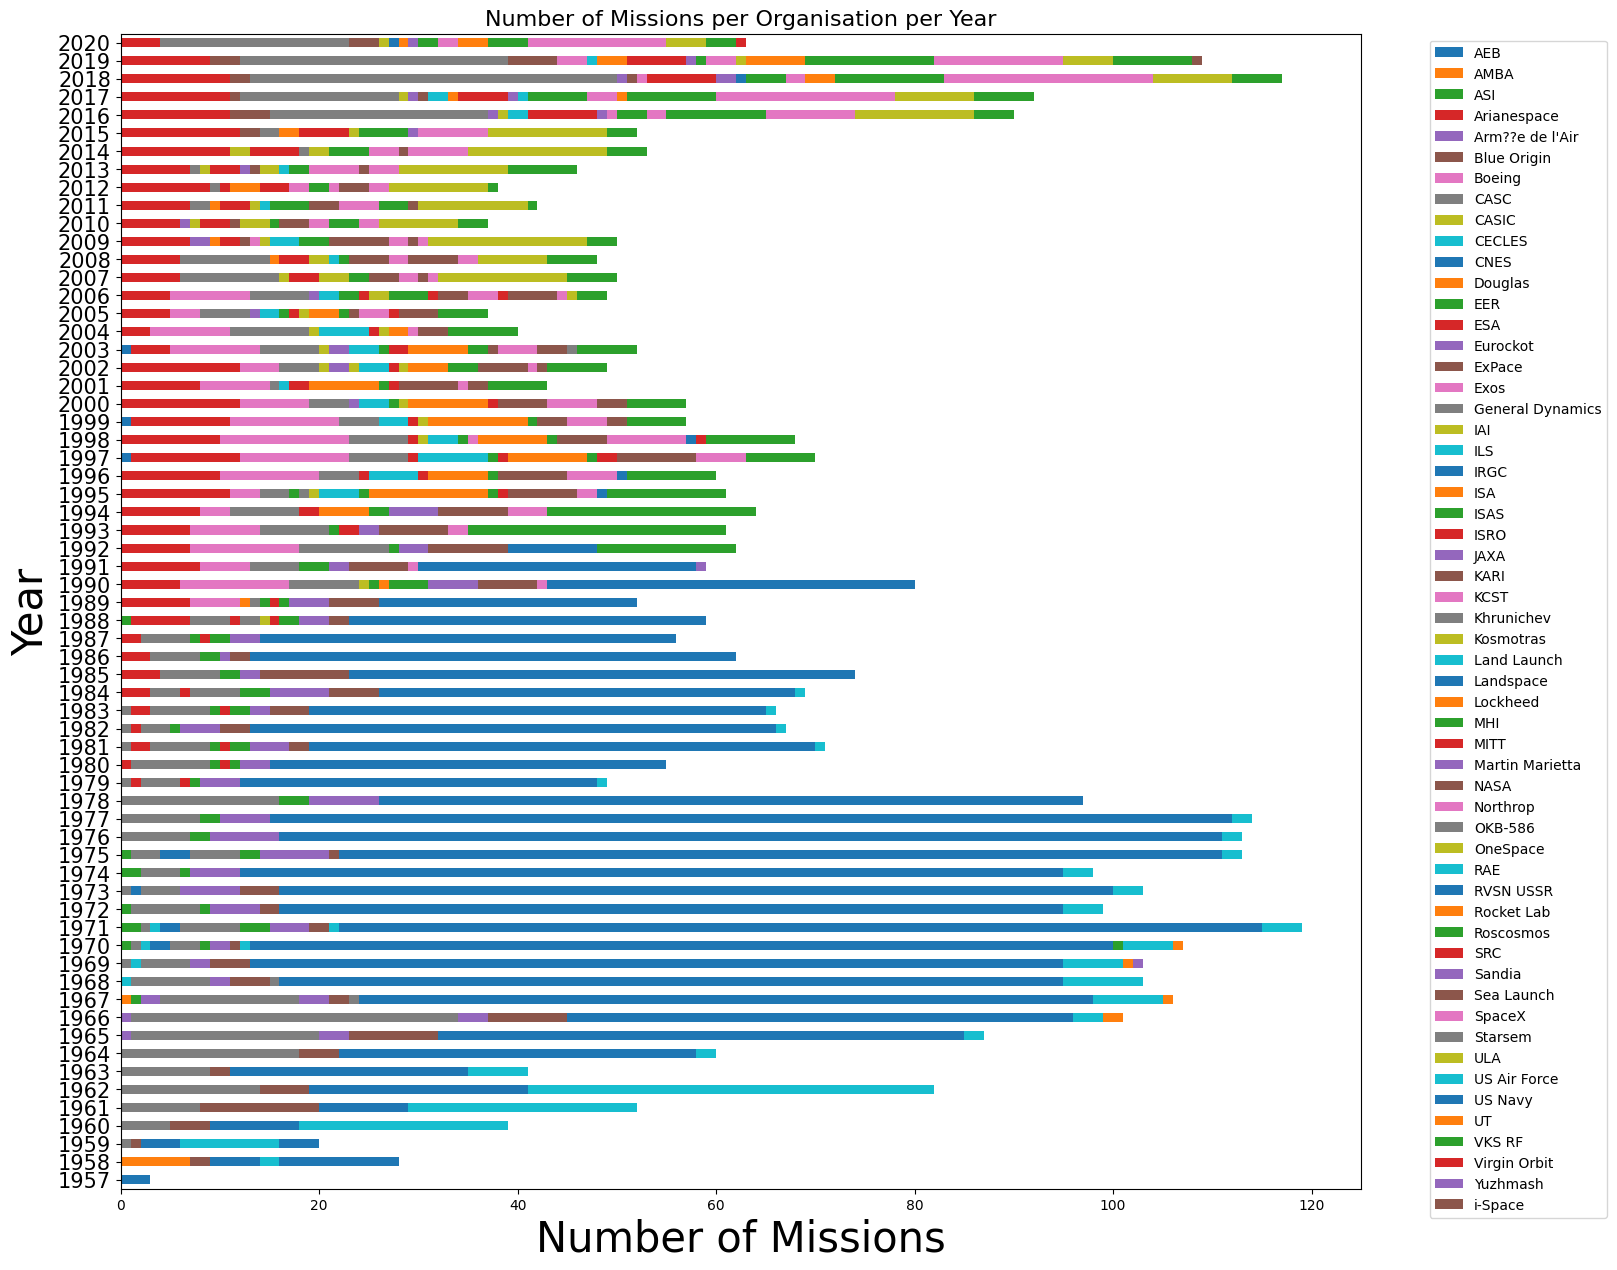

In [25]:
missions_per_org_year = df.groupby(['Year', 'Organisation']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 40))  
missions_per_org_year.plot(kind='barh', figsize=(16,15),stacked=True, width=0.5)  
plt.title('Number of Missions per Organisation per Year', fontsize=16)
plt.ylabel('Year', fontsize=30)
plt.xlabel('Number of Missions', fontsize=30)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()



In [26]:
# Count missions per year and organisation
missions_per_year_org = df.groupby(['Year', 'Organisation']).size().reset_index(name='Mission_Count')

# Obtain the organisation with the maximum missions for each year
top_org_per_year = missions_per_year_org.loc[missions_per_year_org.groupby('Year')['Mission_Count'].idxmax()]

# Sort the result by year
top_org_per_year = top_org_per_year.sort_values('Year')

# Show the result
print(top_org_per_year)


     Year  Organisation  Mission_Count
0    1957     RVSN USSR              2
6    1958       US Navy             12
10   1959  US Air Force             10
15   1960  US Air Force             21
19   1961  US Air Force             23
..    ...           ...            ...
583  2016          CASC             22
611  2017        SpaceX             18
616  2018          CASC             37
632  2019          CASC             27
649  2020          CASC             19

[64 rows x 3 columns]


# How many launches were made per year?

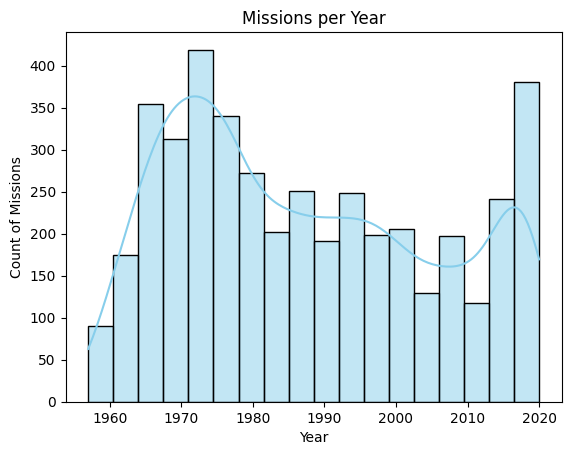

Year
1957      3
1958     28
1959     20
1960     39
1961     52
       ... 
2016     90
2017     92
2018    117
2019    109
2020     63
Length: 64, dtype: int64


In [52]:
missions_per_year = df.groupby(['Year']).size()

sns.histplot(df['Year'], kde=True, color='skyblue')
plt.title('Missions per Year')
plt.xlabel('Year')
plt.ylabel('Count of Missions')
plt.show()
print(missions_per_year)

## How has the cost of a space mission varied over time? 

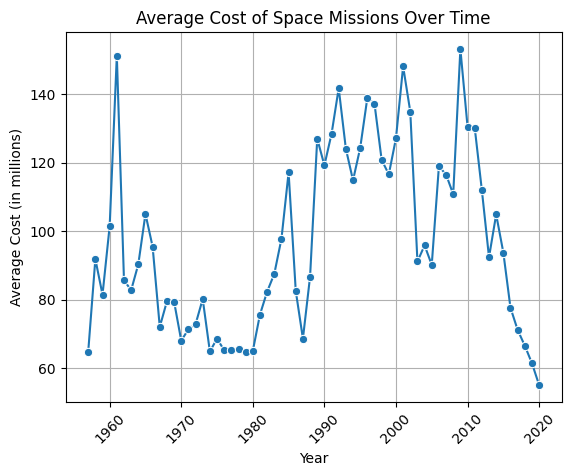

In [29]:
cost_per_year = df.groupby(['Year'])['Price'].mean().reset_index()
sns.lineplot(data=cost_per_year, x='Year', y='Price', marker='o')
plt.title('Average Cost of Space Missions Over Time')   
plt.xlabel('Year')
plt.ylabel('Average Cost (in millions)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Which months are the most popular for launches? 

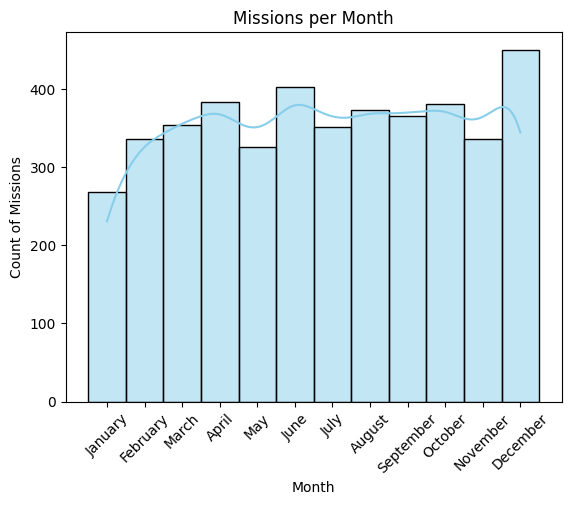

Month
December     450
June         402
April        383
October      381
August       373
September    365
March        353
July         351
November     336
February     336
May          326
January      268
dtype: int64


C:\Users\sebam\AppData\Local\Temp\ipykernel_10220\2825254110.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  launches_per_year = df.groupby('Month').size().sort_values(ascending=False)


In [30]:
sns.histplot(df['Month'], kde=True, color='skyblue')
plt.title('Missions per Month')
plt.xlabel('Month')
plt.ylabel('Count of Missions')
plt.xticks(rotation=45)
plt.show()

launches_per_year = df.groupby('Month').size().sort_values(ascending=False)
print(launches_per_year)

# Have space missions become safer or have the chances of failure remained unchanged? 

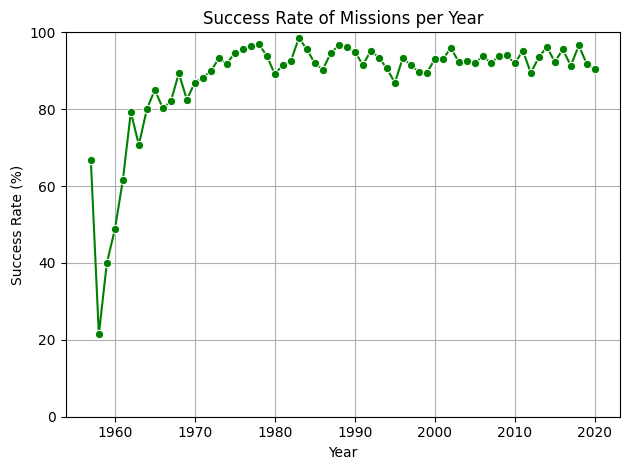

In [ ]:
# Count total missions by year
total_by_year = df.groupby('Year').size()

# Count successful missions by year
success_by_year = df[df['Mission_Status'] == 'Success'].groupby('Year').size()

success_rate = (success_by_year / total_by_year * 100).reset_index(name='Success_Rate')

sns.lineplot(data=success_rate, x='Year', y='Success_Rate', marker='o', color='green')

plt.title('Success Rate of Missions per Year')
plt.xlabel('Year')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()
